In [2]:
%pip install git+https://github.com/LBNL-ETA/FMI-MLC
!pip install casadi

  Cloning https://github.com/LBNL-ETA/FMI-MLC to /tmp/pip-req-build-lstf7eab
  Running command git clone --filter=blob:none --quiet https://github.com/LBNL-ETA/FMI-MLC /tmp/pip-req-build-lstf7eab
  Resolved https://github.com/LBNL-ETA/FMI-MLC to commit c24be53fff0dc27b4df28ee992c4f70d03acf7d1
  Preparing metadata (setup.py) ... done
  Created wheel for FMI-MLC: filename=FMI_MLC-1.0.0-py3-none-any.whl size=8921 sha256=d47fb1e44775905e4d5e1293790461bffac0871210d10a124b5b6de0e756cca1
  Stored in directory: /tmp/pip-ephem-wheel-cache-hzxrvkyx/wheels/ad/21/e3/75c1dccfc12699eb975c865b3f7d7902c348d559127588dad6
Successfully built FMI-MLC

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 MB 7.8 MB/s eta 0:00:00:00:0100:01

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --

In [3]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from pprint import pprint
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

mpl.rcParams['figure.dpi'] = 72


# Get the directory where the current script is located
root = os.getcwd()

# Add the parent directory to the sys.path
sys.path.append(os.path.join(root, '..'))
print(root)


from fmi_mlc import fmi_gym
from fmi_mlc import get_default_parameter

/root/.vscode-server/bin/eaa41d57266683296de7d118f574d0c2652e1fc4


In [100]:
# Define global parameters
R = 8.314
F = 1.602176634 *10**(-19)
M = 5000
m = 1
V_tn = 1.482
T_amb = 273.15 + 23.5
K=1.4

# Electrolyzer parameters
eta_EL = 0.6
eta_F_EL = 0.95 # Faradaic efficiency
P_EL_STB = 285.7
P_EL_nom = 5000
P_EL_max = 5000
P_EL_min = 0.1 * P_EL_max
r_EL = 4500 # 20 W/s or depeds on t_s
C_rep_EL = 0.27*1.55*10**(-3)  # replacement cost (euro/W) - to be multiplied by installed power in W P_EL_nom
N_H_EL = 40000     # number of hours
C_OM_EL = 0.002    # O&M cost (euro/h)
alpha_EL = 1000 * (C_rep_EL * P_EL_nom /N_H_EL + C_OM_EL) # (euro/Wh * W + euro/h)
C_EL = 0.1334
# Electrolyzer auxiliaries parameters


# Fuel cell parameters
eta_FC = 0.4
eta_F_FC = 0.95 # Faradaic efficiency
P_FC_STB = 100
P_FC_nom = 5000
P_FC_max = 4300
P_FC_min = 300
r_FC = 5 * t_s # 5 W/s if t_s < 15min, otherwise = P_FC_max  
C_rep_FC = 0.27*1.55*10**(-3)  # replacement cost for the fuel cell (euro/W) - to be multiplied by installed power in W P_EL_nom
N_H_FC = 40000     # number of hours for the fuel cell (h)
C_OM_FC = 0.01    # O&M cost for the fuel cell (euro/h)
alpha_FC = 1000 * (C_rep_FC * P_FC_nom /N_H_FC + C_OM_FC) # (euro/Wh * W + euro/h)
C_FC=0.018
# Fuel cell auxiliaries parameters


# Hydrogen storage parameters
LOH_min = 0.1 # (1)
LOH_max = 0.99 # (1)
C_max = 5158.1*10**6 # (J), for LHV = 119.96 MJ/kg

# Battery parameters
E_battery_nom = 5000 # (Wh)
C_battery_inv = 0.37  # investment cost for the battery (euro/Wh)
N_battery_cycles = 4000  # number of battery cycles
P_battery_nom = 5000 # (W)
c_battery = C_battery_inv * E_battery_nom / (2 * N_battery_cycles * P_battery_nom) # (euro/W)
eta_batt_ch = 0.98 # (1)
eta_batt_disch = 0.98 # (1)
SOE_min = 500 # (Wh)
SOE_max = 4500 # (Wh)

# Grid arameters
P_grid_max = 6500 # (W)

In [99]:
def optimizer(T, t_s, c_el, pv, load, SOE_initial, LOH_initial): 
    # adapt inputs: T (horizon of simulation), ts (sampling time), SOE_battery, LOH_hess, pv, load, c_el (electricity prices)
    # states: SOE_battery, LOH_hess
    # inputs to FMU: P_battery, P_FC_sys (start with P_FC), P_El_sys (start with P_El), state_FC, state_EL

    # V0: no auxiliaries, no thermal model, no transitions, no STB state, state on-off, no transition, constant efficiency
    # inputs variables in MPC: P_battery_disch, P_battery_ch, P_grid, P_FC, delta_ON_FC, delta_OFF_FC, P_EL, delta_ON_EL, delta_OFF_EL
    
    
    # Access global parameters
    global P_grid_max, P_battery_nom, eta_batt_ch, eta_batt_disch, SOE_min, SOE_max
    global LOH_min, LOH_max, C_max, eta_El, eta_FC, P_EL_min, P_EL_max, P_EL_STB, P_FC_min, P_FC_max, P_FC_STB, r_EL, r_FC
    global alpha_EL, alpha_FC, c_battery

    N = int(T // t_s)
    
    # Initialize
    import casadi as ca
    opti = ca.Opti()

    # -----------------------------
    # Variables and solver
    # -----------------------------

    SOE = opti.variable(1, N+1)  # state
    LOH = opti.variable(1, N+1)  # state
    P_batt = opti.variable(1, N)  # input
    P_grid_sale = opti.variable(1, N)        # input 
    P_grid_pchs = opti.variable(1, N)        # input 
    P_FC = opti.variable(1, N)          # input
    delta_ON_FC = opti.variable(1, N)   # binary input
    delta_OFF_FC = opti.variable(1, N)  # binary input
    P_EL = opti.variable(1, N)          # input
    delta_ON_EL = opti.variable(1, N)   # binary input
    delta_OFF_EL = opti.variable(1, N)  # binary input

    # delta_i are discrete variables (binary)
    discrete_var = [0]*(N+1) + [0]*(N+1) + [0]*N + [0]*N + [0]*N + [0]*N + [1]*N + [1]*N + [0]*N + [1]*N + [1]*N

    # Solver
    opti.solver('bonmin', {'discrete': discrete_var, 'bonmin.tol': 1e-4, 'bonmin.print_level': 0, 'print_time': 0})

    # -----------------------------
    # Constraints
    # -----------------------------

    # Initial storage level
    opti.subject_to(SOE[0] == SOE_initial)
    opti.subject_to(LOH[0] == LOH_initial)

    # Constraints at every time step
    for t in range(N):

            # Bounds on grid
            opti.subject_to(pv[t] + P_grid_pchs[t] + P_FC[t] == load[t] + P_grid_sale[t] + P_batt[t] + P_EL[t])
            opti.subject_to(P_grid_sale[t]>=0)
            opti.subject_to(P_grid_sale[t]<=P_grid_max)
            opti.subject_to(P_grid_pchs[t]>=0)
            opti.subject_to(P_grid_pchs[t]<=P_grid_max)

            # Bounds on battery and SOE
            opti.subject_to(P_batt[t]>=0)
            opti.subject_to(P_batt[t]<=0.9 * P_battery_nom)
        
            opti.subject_to(SOE[t+1] == SOE[t] + P_batt[t] * t_s/3600)
            opti.subject_to(SOE[t] >= SOE_min)
            opti.subject_to(SOE[t] <= SOE_max)
            
            # Bounds on hydrogen storage 
            opti.subject_to(LOH[t+1] == LOH[t] + (P_EL[t] * eta_EL - P_FC[t]/eta_FC) * t_s /C_max)
            opti.subject_to(LOH[t] >= LOH_min)
            opti.subject_to(LOH[t] <= LOH_max)                

            # Constraints on electrolyzer
            # Bounds when ON                
            opti.subject_to(P_EL[t] >= delta_ON_EL[t] * P_EL_min)
            opti.subject_to(P_EL[t] <= delta_ON_EL[t] * P_EL_max)
        
            # Ramping constraints                
            if t < N-1:                
                opti.subject_to(P_EL[t+1] - P_EL[t] <= r_EL)
                opti.subject_to(P_EL[t] - P_EL[t+1] <= r_EL)
                            
            # Constraints on fuel cell
            # Bounds when ON
            opti.subject_to(P_FC[t] >= delta_ON_FC[t] * P_FC_min)
            opti.subject_to(P_FC[t] <= delta_ON_FC[t] * P_FC_max)
            
            # Ramping constraints                
            if t < N-1:                
                opti.subject_to(P_FC[t+1] - P_FC[t] <= r_FC)
                opti.subject_to(P_FC[t] - P_FC[t+1] <= r_FC)
                            
            # States                
            opti.subject_to(delta_ON_EL[t] + delta_OFF_EL[t] == 1)
            opti.subject_to(delta_ON_FC[t] + delta_OFF_FC[t] == 1)


                            
            # Bilinear to linear


    # -----------------------------
    # Objective
    # -----------------------------

    obj = sum(alpha_EL * t_s/3600 * delta_ON_EL[t] + alpha_FC * t_s/3600 * delta_ON_FC[t] + c_battery * ca.fabs(P_batt[t]) + (c_el[t] * P_grid_pchs[t] - 0 * c_el[t] * P_grid_sale[t]) * t_s/3600 for t in range(N))
    opti.minimize(obj)
    
    # -----------------------------
    # Solve and get optimal values
    # -----------------------------

    sol = opti.solve()
    
    SOE_opt = sol.value(SOE)
    LOH_opt = sol.value(LOH)
    P_batt_opt = sol.value(P_batt)
    P_grid_sale_opt = sol.value(P_grid_sale)
    P_grid_pchs_opt = sol.value(P_grid_pchs)
    P_FC_opt = sol.value(P_FC)  
    delta_ON_FC_opt = sol.value(delta_ON_FC)
    delta_OFF_FC_opt = sol.value(delta_OFF_FC)
    P_EL_opt = sol.value(P_EL)
    delta_ON_EL_opt = sol.value(delta_ON_EL)
    delta_OFF_EL_opt = sol.value(delta_OFF_EL)

    obj_opt = round(sol.value(obj), 2)

    return SOE_opt, LOH_opt, P_batt_opt, P_grid_sale_opt, P_grid_pchs_opt, delta_ON_EL_opt, delta_OFF_EL_opt, P_EL_opt, delta_ON_FC_opt, delta_OFF_FC_opt, P_FC_opt, obj_opt
        

In [93]:
def optimizer_V1(T, t_s, c_el, pv, load, SOE_initial, LOH_initial): 
    # states: SOE_battery, LOH_hess
    # inputs to FMU: P_battery, P_FC_sys (start with P_FC), P_El_sys (start with P_El), state_FC, state_EL

    # V2: no auxiliaries, no thermal model, no STB state, add transitions and costs between OFF-On, P_battery convexity managed by adding a continuous abs variable
    # inputs variables in MPC: P_battery, P_grid, P_FC, delta_ON_FC, delta_OFF_FC, sigma_OFF_ON_FC, P_EL, delta_ON_EL, delta_OFF_EL, sigma_OFF_ON_EL
    
    # Access global parameters
    global P_grid_max, P_battery_nom, SOE_min, SOE_max
    global LOH_min, LOH_max, C_max, eta_El, eta_FC, P_EL_min, P_EL_max, P_EL_STB, P_FC_min, P_FC_max, P_FC_STB, r_EL, r_FC
    global alpha_EL, alpha_FC, C_EL, C_FC, c_battery
    

    N = int(T // t_s)
    
    # Initialize
    import casadi as ca
    opti = ca.Opti()

    # -----------------------------
    # Variables and solver
    # -----------------------------

    SOE = opti.variable(1, N+1)  # state
    LOH = opti.variable(1, N+1)  # state
    P_batt = opti.variable(1, N)  # input
    P_batt_abs = opti.variable(1,N)
    P_grid_sale = opti.variable(1, N)        # input 
    P_grid_pchs = opti.variable(1, N)        # input 
    P_FC = opti.variable(1, N)          # input
    delta_ON_FC = opti.variable(1, N)   # binary input
    delta_OFF_FC = opti.variable(1, N)  # binary input
    sigma_OFF_ON_FC = opti.variable(1, N)  # binary input
    P_EL = opti.variable(1, N)          # input
    delta_ON_EL = opti.variable(1, N)   # binary input
    delta_OFF_EL = opti.variable(1, N)  # binary input
    sigma_OFF_ON_EL = opti.variable(1, N)  # binary input


    # delta_i are discrete variables (binary)
    discrete_var = [0]*(N+1) + [0]*(N+1) + [0]*N + [0]*N + [0]*N + [0]*N + [0]*N + [1]*N + [1]*N + [1]*N + [0]*N + [1]*N + [1]*N + [1]*N

    # Solver
    opti.solver('bonmin', {'discrete': discrete_var, 'bonmin.tol': 1e-4, 'bonmin.print_level': 0, 'print_time': 0})

    # -----------------------------
    # Constraints
    # -----------------------------

    
    # Initial storage level
    opti.subject_to(SOE[0] == SOE_initial)
    opti.subject_to(LOH[0] == LOH_initial)

    # Impose initial state of FC and electrolyzer to be OFF
    #opti.subject_to(delta_OFF_EL[0] == 1)
    #opti.subject_to(delta_OFF_FC[0] == 1)

    

    # Constraints at every time step
    for t in range(N):

            # Bounds on grid
            opti.subject_to(pv[t] + P_grid_pchs[t] + P_FC[t] == load[t] + P_grid_sale[t] + P_batt[t] + P_EL[t])
            opti.subject_to(P_grid_sale[t]>=0)
            opti.subject_to(P_grid_sale[t]<=P_grid_max)
            opti.subject_to(P_grid_pchs[t]>=0)
            opti.subject_to(P_grid_pchs[t]<=P_grid_max)

            # Bounds on battery and SOE
            opti.subject_to(P_batt_abs[t] >= P_batt[t])
            opti.subject_to(P_batt_abs[t] >= - P_batt[t])
            
            opti.subject_to(P_batt[t]>= - 0.9 * P_battery_nom)
            opti.subject_to(P_batt[t]<= 0.9 * P_battery_nom)
        
            opti.subject_to(SOE[t+1] == SOE[t] + P_batt[t] * t_s/3600)
            opti.subject_to(SOE[t] >= SOE_min)
            opti.subject_to(SOE[t] <= SOE_max)
            
            # Bounds on hydrogen storage 
            opti.subject_to(LOH[t+1] == LOH[t] + (P_EL[t] * eta_EL - P_FC[t]/eta_FC) * t_s /C_max)
            opti.subject_to(LOH[t] >= LOH_min)
            opti.subject_to(LOH[t] <= LOH_max)                

            # Constraints on electrolyzer
            # Bounds when ON                
            opti.subject_to(P_EL[t] >= delta_ON_EL[t] * P_EL_min)
            opti.subject_to(P_EL[t] <= delta_ON_EL[t] * P_EL_max)
        
            # Ramping constraints                
            if t < N-1:                
                opti.subject_to(P_EL[t+1] - P_EL[t] <= r_EL)
                opti.subject_to(P_EL[t] - P_EL[t+1] <= r_EL)
                            
            # Constraints on fuel cell
            # Bounds when ON
            opti.subject_to(P_FC[t] >= delta_ON_FC[t] * P_FC_min)
            opti.subject_to(P_FC[t] <= delta_ON_FC[t] * P_FC_max)
            
            # Ramping constraints                
            if t < N-1:                
                opti.subject_to(P_FC[t+1] - P_FC[t] <= r_FC)
                opti.subject_to(P_FC[t] - P_FC[t+1] <= r_FC)
                            
            # States                
            opti.subject_to(delta_ON_EL[t] + delta_OFF_EL[t] == 1)
            opti.subject_to(delta_ON_FC[t] + delta_OFF_FC[t] == 1)
            
            # Transitions EL               
            opti.subject_to(sigma_OFF_ON_EL[t] - delta_OFF_EL[t-1] <= 0)
            opti.subject_to(sigma_OFF_ON_EL[t] - delta_ON_EL[t] <= 0)
            opti.subject_to(delta_OFF_EL[t-1] + delta_ON_EL[t] - sigma_OFF_ON_EL[t] <= 1)

            # Transitions FC               
            opti.subject_to(sigma_OFF_ON_FC[t] - delta_OFF_FC[t-1] <= 0)
            opti.subject_to(sigma_OFF_ON_FC[t] - delta_ON_FC[t] <= 0)
            opti.subject_to(delta_OFF_FC[t-1] + delta_ON_FC[t] - sigma_OFF_ON_FC[t] <= 1)


            # Transitions dwwelling time for OFF-STB
            T_CLD_EL = 1 
            T_CLD_FC = 1
             # Electrolyzer constraints
            if t >= 1 and t < N - T_CLD_EL:
                opti.subject_to(sigma_OFF_ON_EL[t] - sigma_OFF_ON_EL[t-1] <= sigma_OFF_ON_EL[t+1:t + T_CLD_EL+1])
                sigma_sum_EL = sum([sigma_OFF_ON_EL[t-j] for j in range(T_CLD_EL)])
                opti.subject_to(sigma_sum_EL <= T_CLD_EL)
    
            # Fuel Cell constraints
            if t >= 1 and t < N - T_CLD_FC:
                opti.subject_to(sigma_OFF_ON_FC[t] - sigma_OFF_ON_FC[t-1] <= sigma_OFF_ON_FC[t+1:t + T_CLD_FC+1])
                sigma_sum_FC = sum([sigma_OFF_ON_FC[t-j] for j in range(T_CLD_FC)])
                opti.subject_to(sigma_sum_FC <= T_CLD_FC)
             
                    
            # Bilinear to linear


    # -----------------------------
    # Objective
    # -----------------------------

    obj = sum(alpha_EL * t_s/3600 * delta_ON_EL[t] + C_EL * sigma_OFF_ON_EL[t] + alpha_FC * t_s/3600 * delta_ON_FC[t] 
    + C_FC * sigma_OFF_ON_FC[t] + c_battery * P_batt_abs[t] + 2 * (10**(-3)*c_el[t] * P_grid_pchs[t] - 10**(-3) *0 * c_el[t] * P_grid_sale[t]) * t_s/3600 for t in range(N))
    opti.minimize(obj)
    
    # -----------------------------
    # Solve and get optimal values
    # -----------------------------

    sol = opti.solve()
    
    SOE_opt = sol.value(SOE)
    LOH_opt = sol.value(LOH)
    P_batt_opt = sol.value(P_batt)
    P_batt_abs_opt = sol.value(P_batt_abs)
    P_grid_sale_opt = sol.value(P_grid_sale)
    P_grid_pchs_opt = sol.value(P_grid_pchs)
    P_FC_opt = sol.value(P_FC)  
    delta_ON_FC_opt = sol.value(delta_ON_FC)
    delta_OFF_FC_opt = sol.value(delta_OFF_FC)
    sigma_OFF_ON_FC_opt = sol.value(sigma_OFF_ON_FC)
    P_EL_opt = sol.value(P_EL)
    delta_ON_EL_opt = sol.value(delta_ON_EL)
    delta_OFF_EL_opt = sol.value(delta_OFF_EL)
    sigma_OFF_ON_EL_opt = sol.value(sigma_OFF_ON_EL)

    obj_opt = round(sol.value(obj), 2)

    return SOE_opt, LOH_opt, P_batt_opt, P_grid_sale_opt, P_grid_pchs_opt, delta_ON_EL_opt, delta_OFF_EL_opt, sigma_OFF_ON_EL_opt, P_EL_opt, delta_ON_FC_opt, delta_OFF_FC_opt, sigma_OFF_ON_FC_opt, P_FC_opt, obj_opt
        

In [1]:
def ctrl_postprocessor(delta_ON_EL, delta_OFF_EL, delta_ON_FC, delta_OFF_FC, P_FC, P_EL, P_grid_pchs, P_grid_sale):
    # Ensure inputs are arrays/lists
    if isinstance(delta_ON_EL, float):
        delta_ON_EL = [delta_ON_EL]
    if isinstance(delta_OFF_EL, float):
        delta_OFF_EL = [delta_OFF_EL]
    if isinstance(delta_ON_FC, float):
        delta_ON_FC = [delta_ON_FC]
    if isinstance(delta_OFF_FC, float):
        delta_OFF_FC = [delta_OFF_FC]
    if isinstance(P_FC, float):
        P_FC = [P_FC]
    if isinstance(P_EL, float):
        P_EL = [P_EL]
    if isinstance(P_grid_pchs, float):
        P_grid_pchs = [P_grid_pchs]
    if isinstance(P_grid_sale, float):
        P_grid_sale = [P_grid_sale]
        
    state_EL = []
    state_FC = []
    P_grid = []

    # Loop over each time step
    for i in range(len(delta_ON_EL)):
        # Determine the state of the electrolyzer
        if delta_ON_EL[i] == 1:
            state_EL.append(2)  # ON state
        elif delta_OFF_EL[i] == 1:
            state_EL.append(0)  # OFF state
        else:
            state_EL.append(1)  # Standby state

        # Determine the state of the fuel cell
        if delta_ON_FC[i] == 1:
            state_FC.append(2)  # ON state
        elif delta_OFF_FC[i] == 1:
            state_FC.append(0)  # OFF state
        else:
            state_FC.append(1)  # Standby state

        # Calculate the net grid power for each time step
        P_grid.append(P_grid_sale[i] - P_grid_pchs[i])

    return np.array(P_FC), np.array(P_EL), np.array(state_FC), np.array(state_EL), np.array(P_grid)


In [2]:
def MPC(states, c_el_slice, pv_slice, load_slice, T, t_s):

    # Debugging: Print out the inputs to ensure they are correct
    print(f"Running MPC with horizon {T}")
    print(f"c_el_slice: {c_el_slice}")
    print(f"pv_slice: {pv_slice}")
    print(f"load_slice: {load_slice}") 
    
    # Initialize action dictionary
    action = {
        'P_battery': 0,
        'P_FC_sys': 0,
        'P_EL_sys': 0,
        'state_FC': 0,
        'state_EL': 0
    }

    tolerance = 1*10**(-2)
    
    # Extract necessary information from inputs
    SOE = states[2]  # Adjust index based on actual state structure
    LOH = states[4]    
    #print(f"SOE initial: {SOE}")
    #print(f"LOH initial: {LOH}")
    
    # V0
    # SOE_opt, LOH_opt, delta_batt, P_grid_sale, P_grid_pchs, delta_ON_EL, delta_OFF_EL, P_EL, delta_ON_FC, delta_OFF_FC, P_FC, obj_opt = optimizer(T, t_s, c_el_slice, pv_slice, load_slice, SOE, LOH)
    # V1
    SOE_opt, LOH_opt, P_batt, P_grid_sale, P_grid_pchs, delta_ON_EL, delta_OFF_EL, sigma_EL, P_EL, delta_ON_FC, delta_OFF_FC, sigma_FC, P_FC, obj_opt = optimizer_V1(T, t_s, c_el_slice, pv_slice, load_slice, SOE, LOH)

    
    # Compute values for action['P_battery'], action['P_EL_sys'], action['P_FC_sys'], action['state_EL'] and action['state_FC']
    P_FC, P_EL, state_FC, state_EL, P_grid = ctrl_postprocessor(delta_ON_EL, delta_OFF_EL, delta_ON_FC, delta_OFF_FC, P_FC, P_EL, P_grid_pchs, P_grid_sale)

    print(f"Battery setpoint: {P_batt[0]}")

    #if isinstance(P_batt, float):
    #    P_batt = [P_batt]
    # Update action dictionary with the first value of each vector
    action['P_battery'] = P_batt[0]
    action['P_FC_sys'] = P_FC[0]
    action['P_EL_sys'] = P_EL[0]
    action['state_FC'] = state_FC[0]
    action['state_EL'] = state_EL[0]

    for key in ['P_battery', 'P_EL_sys', 'P_FC_sys']:
        if abs(action[key]) < tolerance:
            action[key] = 0
     
    # Convert action dictionary to a list of values
    action_list = list(action.values())
    # Round each action to 2 decimal places
    action_list = [round(a, 2) for a in action_list]

     # Create the observation DataFrame: take 2nd element of SOE and LOH as first elemet is the initial state given by the FMU
    observation = pd.DataFrame({
        'SOE': [SOE_opt[1]],
        'LOH': [LOH_opt[1]],
        'P_grid': [P_grid[0]], 
        'Objective': [obj_opt]
    })
    
    return action_list, observation

In [96]:
# class controller
class controller:
    def __init__(self, c_el, pv, load, T, t_s):
        self.c_el = c_el
        self.pv = pv
        self.load = load
        self.T = int(T // t_s)
        self.t_s = t_s
        self.iteration = 0

    def do_step(self, state):
        k = self.iteration 

        #print("c_el before slicing:", self.c_el)

        # Extract the relevant slice from the pv and load vectors
        c_el_slice = self.c_el[k:k + self.T]
        pv_slice = self.pv[k:k + self.T]
        load_slice = self.load[k:k + self.T]

        #print("c_el_slice:", c_el_slice)

        # If we're at the end and slices are too short wrto initial time horizon, pad with 0
        if len(c_el_slice) < self.T:
            pv_slice = np.pad(pv_slice, (0, self.T - len(pv_slice)), 'constant', constant_values=0)
            load_slice = np.pad(load_slice, (0, self.T - len(load_slice)), 'constant', constant_values=0)
            c_el_slice = np.pad(c_el_slice, (0, self.T - len(c_el_slice)), 'constant', constant_values=0)


        # Controller logic using state, pv_slice, and load_slice
        action, observation = MPC(state, c_el_slice, pv_slice, load_slice, T, t_s)
        
        # Increment the iteration counter
        self.iteration += 1
        
        return action, observation
        


# fmi_gym parameter initialization for the dry run
parameter = {}

parameter['seed'] = 1
parameter['store_data'] = True

# fmu parameter initialization
dtype = np.float64
parameter['fmu_step_size'] = t_s
parameter['fmu_path'] = os.path.join(root, '/home/alienor/Documents/hess/MPC-FMU/FMU/H2Microgrid_0TransiEnt_HybridMicrogrid_H2Microgrid_0HP.fmu') #/home/alienor is the way to access my folders via the container
print(f"Root directory: {root}")
print("FMU Path:", parameter['fmu_path'])
parameter['fmu_start_time'] = 165*24*60*60 + 0*60*60
parameter['fmu_warmup_time'] = 0*60*60
parameter['fmu_final_time'] = 166*24*60*60 + 0*60*60 + T
# if you need to overwrite used weather file in model. Same for load file.
#parameter['fmu_param'] = {'weaDat.weather_file': '/home/alienor/Documents/hess/H2Microgrid_TransiEnt/Resources/weather/USA_CA_Los.Angeles.Intl.AP.722950_TMY3.mos'}

# find a way to overwrite initalization of battery SOC and HESS SOC

# data exchange parameter
parameter['action_names'] = ['P_set_battery', 'P_set_FC', 'P_set_EL', 'state_FC', 'state_EL' ]
parameter['action_min'] = np.array([-1e4, 0, 0, 0, 0], dtype=dtype) # can ignore this, can set to [-1e3] * len(action_names)
parameter['action_max'] = np.array([1e4, 1e4, 1e4, 0, 0], dtype=dtype) 
parameter['observation_names'] = ['P_PV', 'P_load', 'SOE_battery', 'P_battery', 'LOH', 'P_EL', 'P_FC']

env = fmi_gym(parameter)

Root directory: /root/.vscode-server/bin/eaa41d57266683296de7d118f574d0c2652e1fc4
FMU Path: /home/alienor/Documents/hess/MPC-FMU/FMU/H2Microgrid_0TransiEnt_HybridMicrogrid_H2Microgrid_0HP.fmu


In [59]:
# MPC time parameters
T = 24*60*60  # horizon time (at each iteration, optimization horizon - can be different than simulation duration
t_s = 15*60  # Time step size in seconds: ts = 1h -> for not losing too much on transitions for HESS, ideally ts should be smaller or equal to tau_CLD
N = int(T//t_s) # Number of iteration in 1 optimization

In [60]:
# Initialize the environment 
# Dry run to read PV and load profiles on entire simulation, and use them as forecasts
done = False
state = env.reset()

# Run the simulation
while not done:
    action = env.action_space.sample() # random test without actions computed by controller --> good dry run to read PV and load profiles!
    state, reward, done, info = env.step(action)
    
    if done:
        dry = env.data.copy(deep=True)
        state = env.reset()
env.close()


  Tag: simulation.nonlinear[9] during event iteration at time 1.42617e+07.


  Tag: simulation.nonlinear[9] during event iteration at time 1.42697e+07.


  Tag: simulation.nonlinear[9] during event iteration at time 1.4271e+07.


  Tag: simulation.nonlinear[9] during event iteration at time 1.42723e+07.


  Tag: simulation.nonlinear[9] during event iteration at time 1.4273e+07.


  Tag: simulation.nonlinear[9] during event iteration at time 1.42764e+07.


  Tag: simulation.nonlinear[9] during event iteration at time 1.42795e+07.


  Tag: simulation.nonlinear[9] during event iteration at time 1.42808e+07.


  Tag: simulation.nonlinear[9] during event iteration at time 1.42816e+07.


  Tag: simulation.nonlinear[9] during event iteration at time 1.42897e+07.


  Tag: simulation.nonlinear[9] during event iteration at time 1.42907e+07.


  Tag: simulation.nonlinear[9] during event iteration at time 1.42909e+07.


  Tag: simulation.nonlinear[9] during event iteration at time 1.43051e+07.




In [61]:
# When timestep is a multiple of 1 hour
dry.index = [pd.to_datetime('2021-01-01') + pd.DateOffset(seconds=ix) for ix in dry.index]


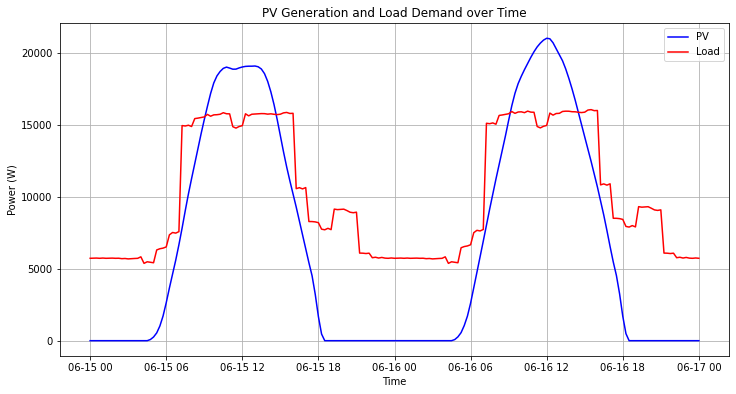

In [62]:
# When timestep is not a multiple of 1 hour
# Reference time
reference_time = pd.to_datetime('2021-01-01')

# Convert Timestamps to seconds
dry.index = (dry.index - reference_time).total_seconds().astype(int)

# Generate the new index
dry.index = [reference_time + pd.DateOffset(seconds=ix) for ix in dry.index]

dry = dry[['time', 'P_PV', 'P_load']]

#plot
plt.figure(figsize=(12, 6))

plt.plot(dry.index, dry['P_PV'], label='PV', color='blue')
plt.plot(dry.index, dry['P_load'], label='Load', color='red')

plt.title('PV Generation and Load Demand over Time')
plt.xlabel('Time')
plt.ylabel('Power (W)')
plt.legend()
plt.grid(True)
plt.show()

In [71]:
# overwrite fmi_gym parameter for the simulation in order to generate less forecasts 
#parameter = {}

parameter['seed'] = 1
parameter['store_data'] = True

# fmu parameter initialization
dtype = np.float64
parameter['fmu_step_size'] = t_s
parameter['fmu_path'] = os.path.join(root, '/home/alienor/Documents/hess/MPC-FMU/FMU/H2Microgrid_0TransiEnt_HybridMicrogrid_H2Microgrid_0HP.fmu') #/home/alienor is the way to access my folders via the container
print(f"Root directory: {root}")
print("FMU Path:", parameter['fmu_path'])
parameter['fmu_start_time'] = 165*24*60*60 + 0*60*60
parameter['fmu_warmup_time'] = 0*60*60
parameter['fmu_final_time'] = 166*24*60*60 + 0*60*60
# if you need to overwrite used weather file in model. Same for load file.
#parameter['fmu_param'] = {'weaDat.weather_file': '/home/alienor/Documents/hess/H2Microgrid_TransiEnt/Resources/weather/USA_CA_Los.Angeles.Intl.AP.722950_TMY3.mos'}

# find a way to overwrite initalization of battery SOC and HESS SOC

# data exchange parameter
parameter['action_names'] = ['P_set_battery', 'P_set_FC', 'P_set_EL', 'state_FC', 'state_EL' ]
parameter['action_min'] = np.array([-1e4, 0, 0, 0, 0], dtype=dtype) # can ignore this, can set to [-1e3] * len(action_names)
parameter['action_max'] = np.array([1e4, 1e4, 1e4, 0, 0], dtype=dtype) 
parameter['observation_names'] = ['P_PV', 'P_load', 'SOE_battery', 'P_battery', 'LOH', 'P_EL', 'P_FC']

env = fmi_gym(parameter)

L = int((parameter['fmu_final_time'] - parameter['fmu_start_time']) // t_s) # Number of timesteps in 1 simulation

Root directory: /root/.vscode-server/bin/eaa41d57266683296de7d118f574d0c2652e1fc4
FMU Path: /home/alienor/Documents/hess/MPC-FMU/FMU/H2Microgrid_0TransiEnt_HybridMicrogrid_H2Microgrid_0HP.fmu


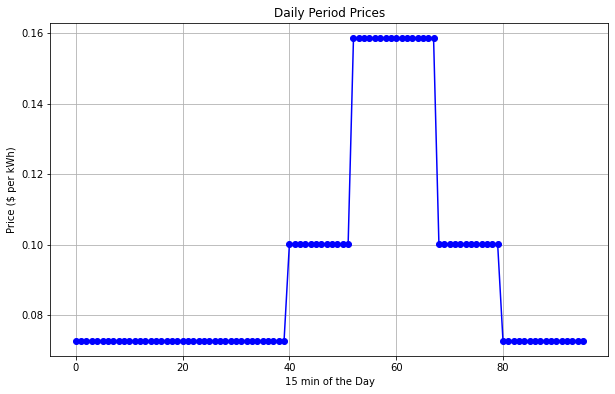

In [72]:
# Electricity prices at a 15min sampling time
# High Season Weekday
high_season_weekday_15min = np.array(
    [0.07274]*40 + [0.10018]*12 + [0.15858]*16 + [0.10018]*12 + [0.07274]*16
)

# High Season Weekend
high_season_weekend_15min = np.array([0.07274]*96)

# Low Season Weekday
low_season_weekday_15min = np.array(
    [0.07664]*40 + [0.10018]*12 + [0.10018]*16 + [0.10018]*12 + [0.07664]*16
)

# Low Season Weekend
low_season_weekend_15min = np.array([0.07664]*96)


c_el_2days_highweekday = np.tile(high_season_weekday_15min, 2)


# Create a time vector for the 24 hours 
hours = range(24*4)

# Plotting the prices
plt.figure(figsize=(10, 6))
plt.plot(hours, high_season_weekday_15min, marker='o', linestyle='-', color='blue')

# Add labels and title
plt.xlabel('15 min of the Day')
plt.ylabel('Price ($ per kWh)')
plt.title('Daily Period Prices')
plt.grid(True)

# Show the plot
plt.show()

In [101]:
# Assuming dry['P_PV'] and dry['P_load'] are our pv and load vectors + random cost vector

pv = dry['P_PV'].values
load = dry['P_load'].values

# Initialize an empty list to store observations
observations_list = []

# Create an instance of the controller with pv and load vectors
ctrl = controller(c_el_2days_highweekday, pv, load, T, t_s)

# Run the simulation
done = False
state = env.reset()

while not done:
    # Assuming SOE_battery is at index 3 and SOC_HESS is at index 5 in the state array
    soe_battery = state[2]  # Adjust index based on actual structure
    loh = state[4]    # using state(k-1) and data(k-1) to compute action(k-1) which is applied in k - data must be shifted to k in results df
    
    # Print SOE_battery and SOC_HESS at each iteration
    print(f"Iteration {ctrl.iteration}: SOE = {soe_battery}, LOH = {loh}")
    

    # Get action using the do_step method
    action, observation = ctrl.do_step(state)
    
    # Print the action to verify
    print("Action computed from the controller:", action)

    # Take a step in the environment using the computed action
    state, reward, done, info = env.step(action)

    print(f"States for next iteration= {state}, Reward: {reward}, Done? {done},  Info: {info} ")
    
    # Append the current observation to the list
    observations_list.append(observation)
    
    
    if done:
        res = env.data.copy(deep=True)
        state = env.reset()

env.close()


Iteration 0: SOE = 2500.0, LOH = 0.5
Running MPC with horizon 86400
c_el_slice: [0.07274 0.07274 0.07274 0.07274 0.07274 0.07274 0.07274 0.07274 0.07274
 0.07274 0.07274 0.07274 0.07274 0.07274 0.07274 0.07274 0.07274 0.07274
 0.07274 0.07274 0.07274 0.07274 0.07274 0.07274 0.07274 0.07274 0.07274
 0.07274 0.07274 0.07274 0.07274 0.07274 0.07274 0.07274 0.07274 0.07274
 0.07274 0.07274 0.07274 0.07274 0.10018 0.10018 0.10018 0.10018 0.10018
 0.10018 0.10018 0.10018 0.10018 0.10018 0.10018 0.10018 0.15858 0.15858
 0.15858 0.15858 0.15858 0.15858 0.15858 0.15858 0.15858 0.15858 0.15858
 0.15858 0.15858 0.15858 0.15858 0.15858 0.10018 0.10018 0.10018 0.10018
 0.10018 0.10018 0.10018 0.10018 0.10018 0.10018 0.10018 0.10018 0.07274
 0.07274 0.07274 0.07274 0.07274 0.07274 0.07274 0.07274 0.07274 0.07274
 0.07274 0.07274 0.07274 0.07274 0.07274 0.07274]
pv_slice: [    0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.  

: 

In [74]:
# When timestep is a multiple of 1 hour
res.index = [pd.to_datetime('2021-01-01') + pd.DateOffset(seconds=ix) for ix in res.index]

In [75]:
# When timestep is not a multiple of 1 hour
# Reference time
reference_time = pd.to_datetime('2021-01-01')

# Convert Timestamps to seconds
res.index = (res.index - reference_time).total_seconds().astype(int)

# Generate the new index
res.index = [reference_time + pd.DateOffset(seconds=ix) for ix in res.index]

# Shift the 'P_PV' and 'P_load' columns down by 1 row, filling the first value with 0
res['P_PV'] = res['P_PV'].shift(1, fill_value=0)
res['P_load'] = res['P_load'].shift(1, fill_value=0)

res

,time,P_set_battery,P_set_FC,P_set_EL,state_FC,state_EL,LOH,P_FC,P_load,P_EL,P_battery,P_PV,SOE_battery,reward
2021-06-15 00:00:00,14256000.0,0,0,0,0,0,0.500000,0.0,0.000000,0.0,0.0,0.0,2500.0,-1
2021-06-15 00:15:00,14256900.0,0,0,0,0,0,0.500000,0.0,5721.577462,0.0,0.0,0.0,2500.0,-1
2021-06-15 00:30:00,14257800.0,0,0,0,0,0,0.499999,0.0,5725.215187,0.0,0.0,0.0,2500.0,-1
2021-06-15 00:45:00,14258700.0,0,0,0,0,0,0.499999,0.0,5736.032613,0.0,0.0,0.0,2500.0,-1
2021-06-15 01:00:00,14259600.0,0,0,0,0,0,0.499999,0.0,5721.220041,0.0,0.0,0.0,2500.0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-15 23:00:00,14338800.0,0,0,0,0,0,0.499969,0.0,5738.815176,0.0,0.0,0.0,2500.0,-1
2021-06-15 23:15:00,14339700.0,0,0,0,0,0,0.499968,0.0,5780.583874,0.0,0.0,0.0,2500.0,-1
2021-06-15 23:30:00,14340600.0,0,0,0,0,0,0.499968,0.0,5732.563292,0.0,0.0,0.0,2500.0,-1
2021-06-15 23:45:00,14341500.0,0,0,0,0,0,0.499968,0.0,5720.374836,0.0,0.0,0.0,2500.0,-1


In [76]:
# Concatenate all observations into a single DataFrame
obs_raw = pd.concat(observations_list, ignore_index=True)

obs_raw.index = [pd.to_datetime('2021-01-01') + pd.DateOffset(hours=ix) for ix in obs_raw.index]

# Step 1: Create a new DataFrame for the first row
initial_row = pd.DataFrame({
    'SOE': [res['SOE_battery'].iloc[0]],
    'LOH': [res['LOH'].iloc[0]],
    'Objective': 0,
    'P_grid': 0,
}, index=[obs_raw.index[0]])


# Step 2: Concatenate the new row with the shifted DataFrame
obs = pd.concat([initial_row, obs_raw], ignore_index=False)

# Step 3: Reset the index if needed to maintain consistency
obs.index = res.index

obs

,SOE,LOH,Objective,P_grid
2021-06-15 00:00:00,2500.0,0.500000,0.0,0.000000
2021-06-15 00:15:00,2500.0,0.500000,8.2,-5721.577461
2021-06-15 00:30:00,2500.0,0.500000,8.2,-5725.215187
2021-06-15 00:45:00,2500.0,0.499999,8.2,-5736.032613
2021-06-15 01:00:00,2500.0,0.499999,8.2,-5721.220041
...,...,...,...,...
2021-06-15 23:00:00,2500.0,0.499969,8.3,-5738.815176
2021-06-15 23:15:00,2500.0,0.499969,8.3,-5780.583873
2021-06-15 23:30:00,2500.0,0.499968,8.3,-5732.563291
2021-06-15 23:45:00,2500.0,0.499968,8.3,-5720.374836


In [77]:
res['P_PV'] + res['P_FC'] - obs['P_grid'] - res['P_EL'] - res['P_battery'] - res['P_load'] 

2021-06-15 00:00:00    0.000000e+00
2021-06-15 00:15:00   -2.012985e-07
2021-06-15 00:30:00   -2.012994e-07
2021-06-15 00:45:00   -2.012994e-07
2021-06-15 01:00:00   -2.012994e-07
                           ...     
2021-06-15 23:00:00   -2.012712e-07
2021-06-15 23:15:00   -2.012712e-07
2021-06-15 23:30:00   -2.012703e-07
2021-06-15 23:45:00   -2.012712e-07
2021-06-16 00:00:00   -2.012712e-07
Length: 97, dtype: float64

### Plot 

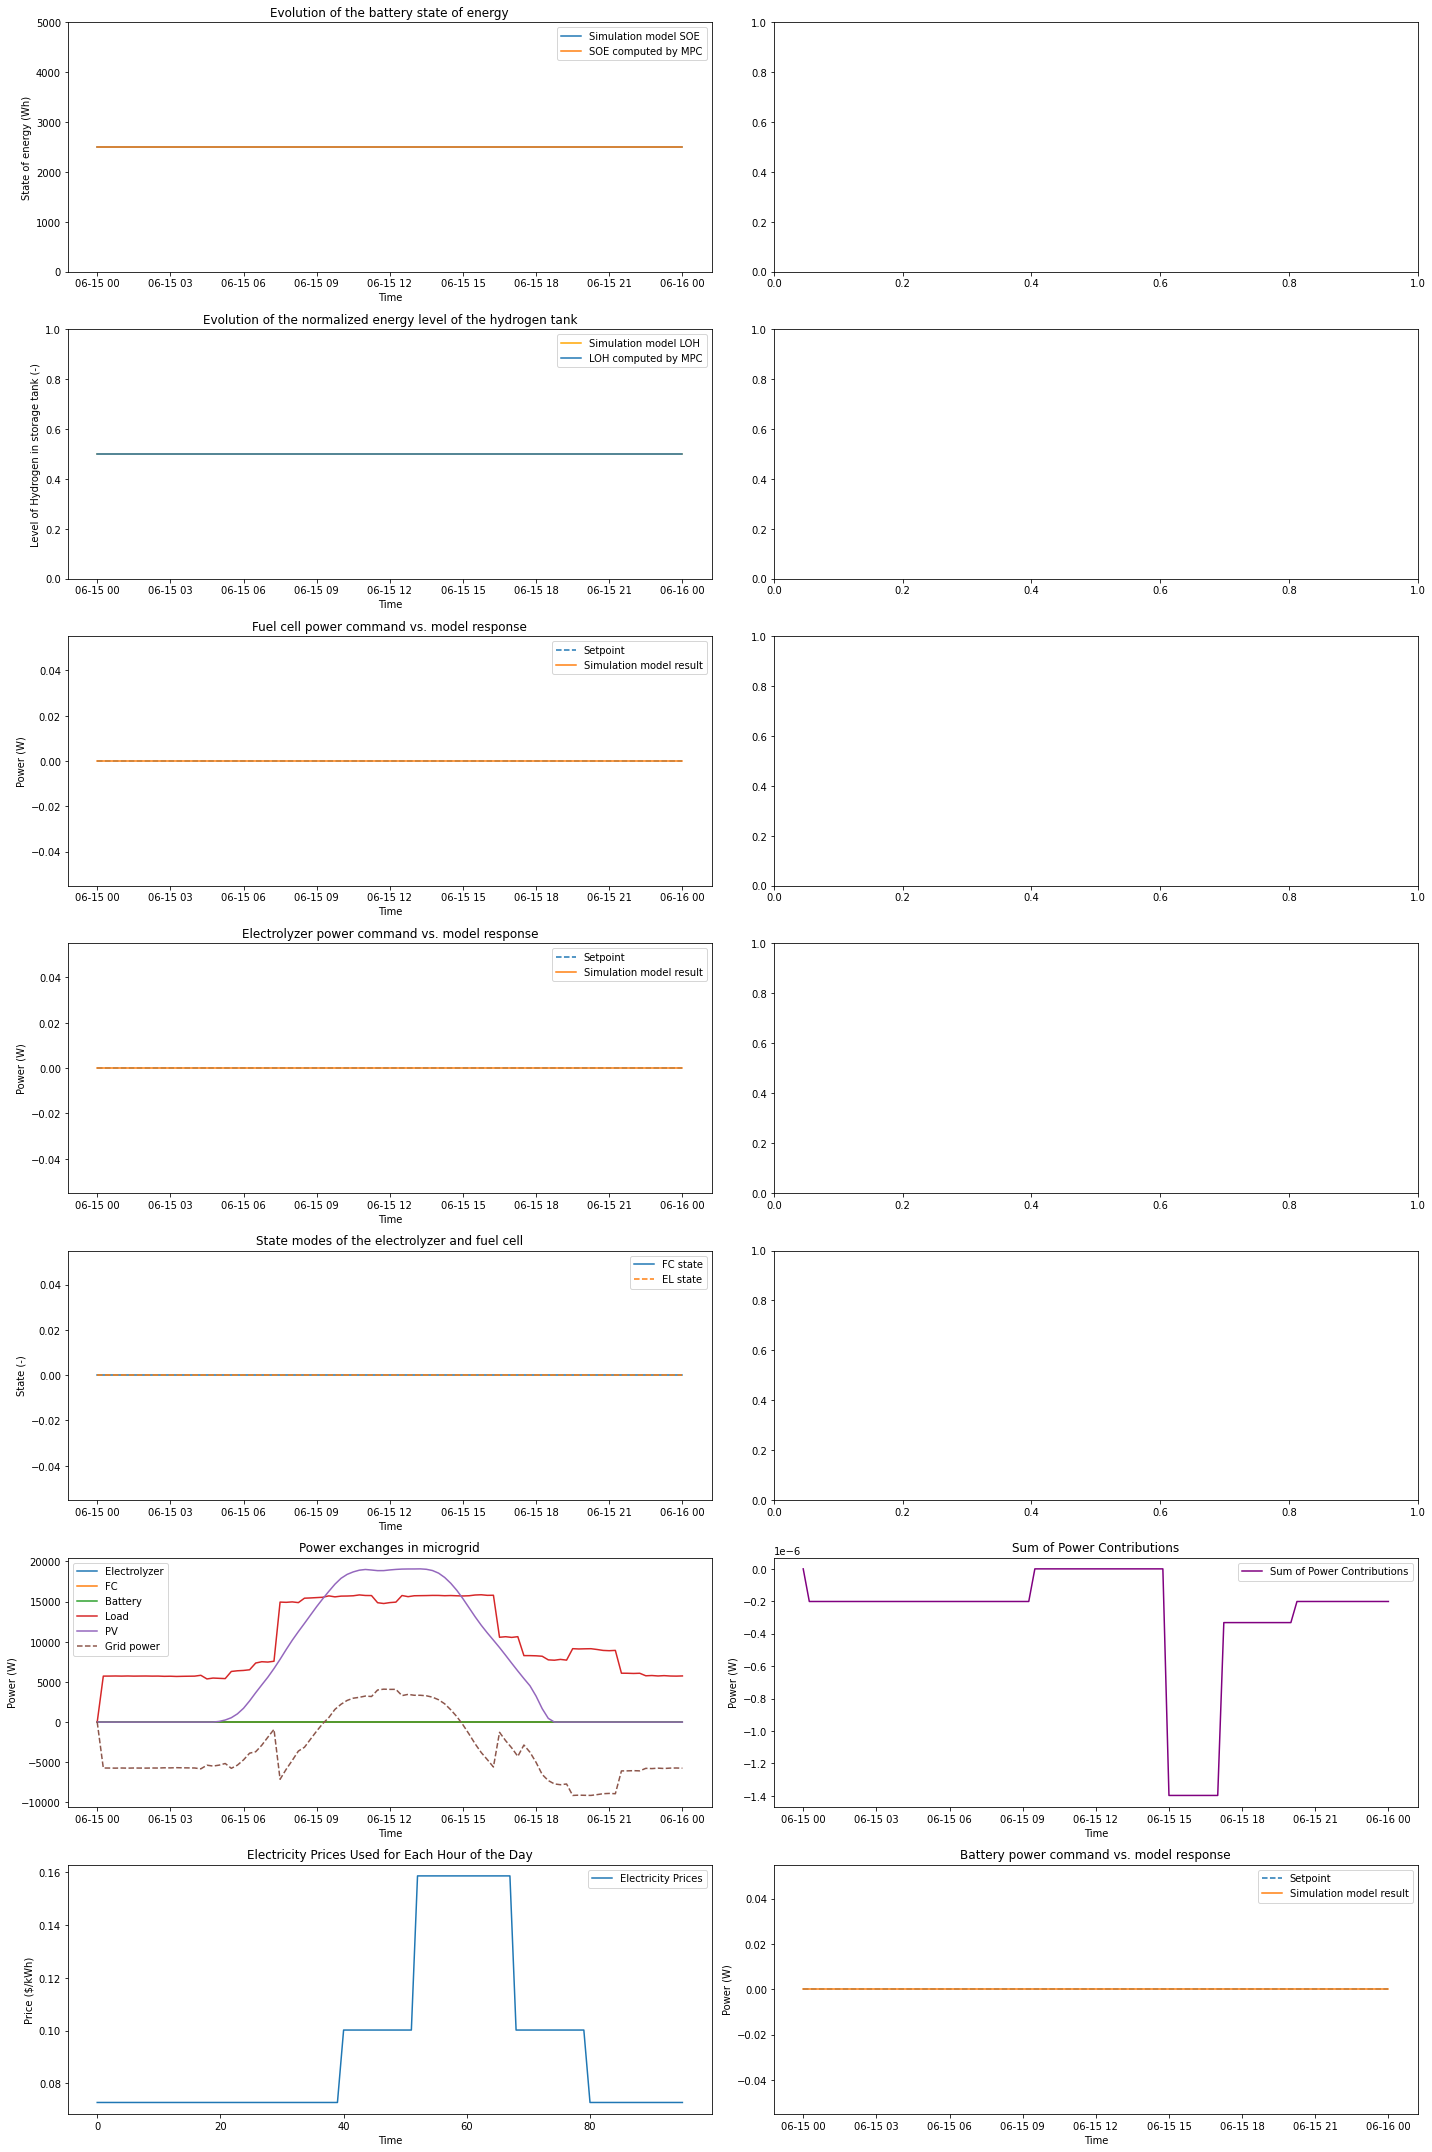

In [79]:
import matplotlib.pyplot as plt


import matplotlib.pyplot as plt

# Assuming you have the electricity prices in a variable named 'c_el'
# If c_el has one value for each 15 minutes, you'll need to adjust the time vector accordingly.

# Create subplots with 8 rows and 2 columns, share the x-axis for easier comparison
fig, axs = plt.subplots(7, 2, figsize=(20, 30))

# Plot SOE_battery
axs[0, 0].plot(res['SOE_battery'], label='Simulation model SOE')
axs[0, 0].plot(obs['SOE'], label='SOE computed by MPC')
axs[0, 0].set_title('Evolution of the battery state of energy')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('State of energy (Wh)')
axs[0, 0].set_ylim(0, 5000)  # Set y-axis limits between 0 and 5000 Wh
axs[0, 0].legend()

# Plot LOH
axs[1, 0].plot(res['LOH'], label='Simulation model LOH', color='orange')
axs[1, 0].plot(obs['LOH'], label='LOH computed by MPC')
axs[1, 0].set_title('Evolution of the normalized energy level of the hydrogen tank')
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('Level of Hydrogen in storage tank (-)')
axs[1, 0].set_ylim(0, 1)  # Set y-axis limits between 0 and 1
axs[1, 0].legend()

# Plot P_set_FC vs P_FC
axs[2, 0].plot(res['P_set_FC'], label='Setpoint', linestyle='--')
axs[2, 0].plot(-res['P_FC'], label='Simulation model result')
axs[2, 0].set_title('Fuel cell power command vs. model response')
axs[2, 0].set_xlabel('Time')
axs[2, 0].set_ylabel('Power (W)')
axs[2, 0].legend()

# Plot P_set_EL vs P_EL
axs[3, 0].plot(res['P_set_EL'], label='Setpoint', linestyle='--')
axs[3, 0].plot(res['P_EL'], label='Simulation model result')
axs[3, 0].set_title('Electrolyzer power command vs. model response')
axs[3, 0].set_xlabel('Time')
axs[3, 0].set_ylabel('Power (W)')
axs[3, 0].legend()

# Plot state_FC and state_EL
axs[4, 0].plot(res['state_FC'], label='FC state')
axs[4, 0].plot(res['state_EL'], label='EL state', linestyle='--')
axs[4, 0].set_title('State modes of the electrolyzer and fuel cell')
axs[4, 0].set_xlabel('Time')
axs[4, 0].set_ylabel('State (-)')
axs[4, 0].legend()

# Plot Power balance with P_EL, P_FC, P_battery, P_load, P_PV, P_grid
axs[5, 0].plot(res['P_EL'], label='Electrolyzer')
axs[5, 0].plot(res['P_FC'], label='FC')
axs[5, 0].plot(res['P_battery'], label='Battery')
axs[5, 0].plot(res['P_load'], label='Load')
axs[5, 0].plot(res['P_PV'], label='PV')
axs[5, 0].plot(obs['P_grid'], label='Grid power', linestyle='--')
axs[5, 0].set_title('Power exchanges in microgrid')
axs[5, 0].set_xlabel('Time')
axs[5, 0].set_ylabel('Power (W)')
axs[5, 0].legend()

# Calculate and plot the sum of all power contributions
power_sum = res['P_PV'] + res['P_FC'] - obs['P_grid'] - res['P_EL'] - res['P_battery'] - res['P_load'] 
axs[5, 1].plot(power_sum, label='Sum of Power Contributions', color='purple')
axs[5, 1].set_title('Sum of Power Contributions')
axs[5, 1].set_xlabel('Time')
axs[5, 1].set_ylabel('Power (W)')
axs[5, 1].legend()

# Plot electricity prices
axs[6, 0].plot(high_season_weekday_15min, label='Electricity Prices')
axs[6, 0].set_title('Electricity Prices Used for Each Hour of the Day')
axs[6, 0].set_xlabel('Time')
axs[6, 0].set_ylabel('Price ($/kWh)')
axs[6, 0].legend()

# Plot P_set_battery vs P_battery
axs[6, 1].plot(res['P_set_battery'], label='Setpoint', linestyle='--')
axs[6, 1].plot(res['P_battery'], label='Simulation model result')
axs[6, 1].set_title('Battery power command vs. model response')
axs[6, 1].set_xlabel('Time')
axs[6, 1].set_ylabel('Power (W)')
axs[6, 1].legend()

# Adjust layout
plt.tight_layout()
plt.show()



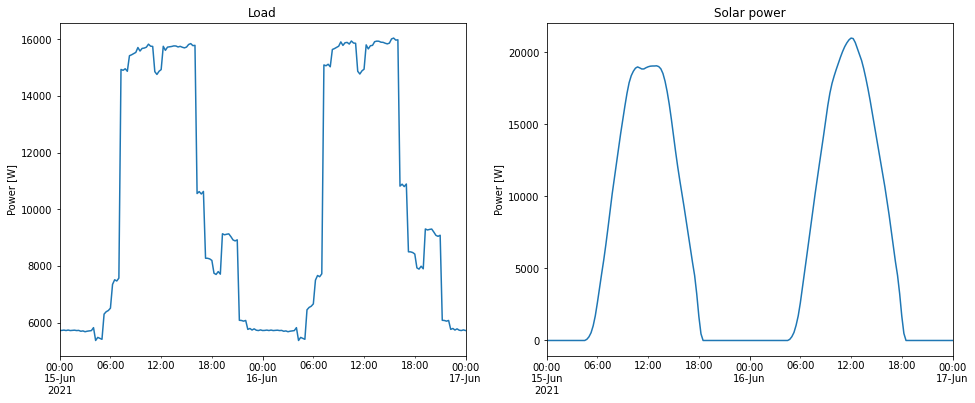

In [80]:
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=False)
axs = axs.ravel()

# Plot difference between P_PV and P_load
dry['P_load'].plot(ax=axs[0])
axs[0].set_ylabel('Power [W]')
axs[0].set_title('Load forecasts')

# Plot P_EL and P_FC
dry['P_PV'].plot(ax=axs[1])
axs[1].set_ylabel('Power [W]')
axs[1].set_title('Solar power forecasts')

# Show plot
plt.show()

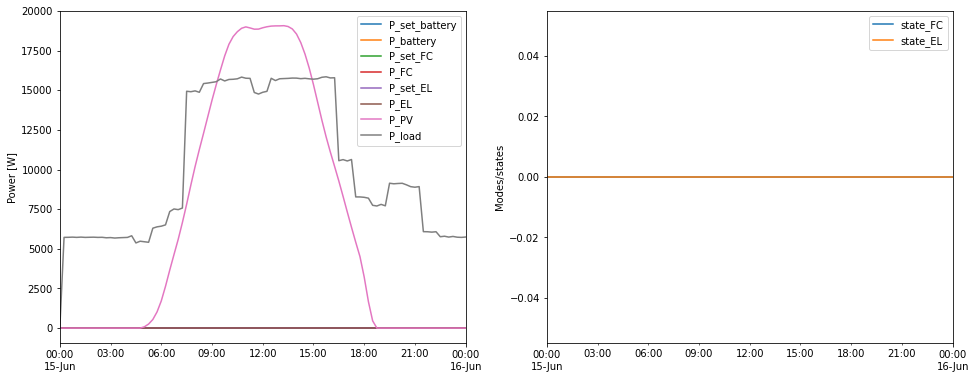

In [81]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=False)
axs = axs.ravel()
res[['P_set_battery', 'P_battery', 'P_set_FC', 'P_FC', 'P_set_EL', 'P_EL', 'P_PV', 'P_load']].plot(ax=axs[0])
axs[0].set_ylabel('Power [W]')
res[['state_FC', 'state_EL']].plot(ax=axs[1])
axs[1].set_ylabel('Modes/states')
plt.show()

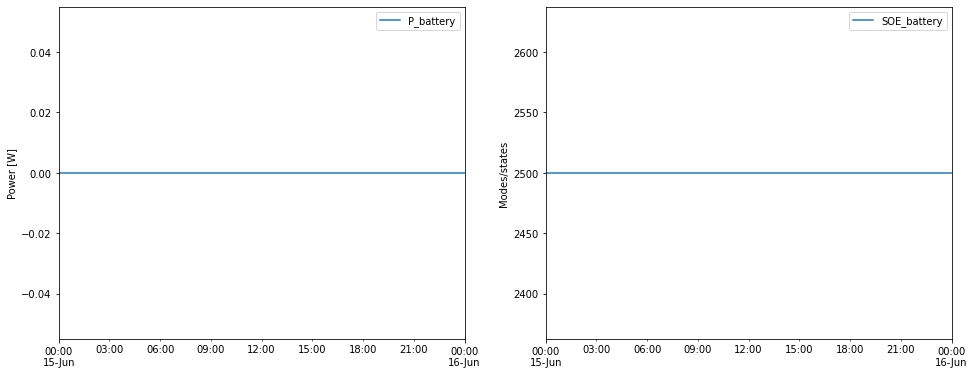

In [82]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=False)
axs = axs.ravel()
res[['P_battery']].plot(ax=axs[0])
axs[0].set_ylabel('Power [W]')
res[['SOE_battery']].plot(ax=axs[1])
axs[1].set_ylabel('Modes/states')
plt.show()

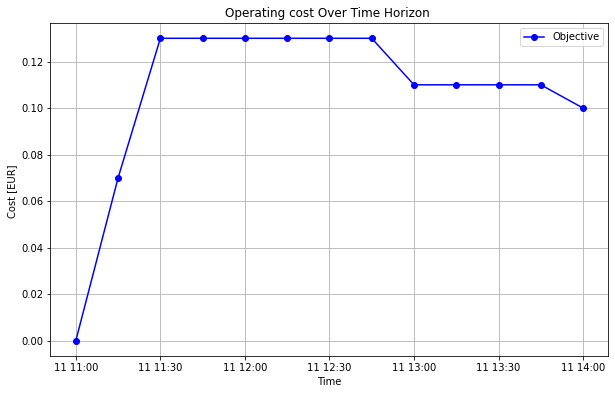

In [51]:
obs_exc_las = obs.iloc[:-1]

# Plotting the Objective over time (excluding the last time point)
plt.figure(figsize=(10, 6))
plt.plot(obs['Objective'], marker='o', linestyle='-', color='blue', label='Objective')
plt.title('Operating cost Over Time Horizon ')
plt.xlabel('Time')
plt.ylabel('Cost [EUR] ')
plt.grid(True)
plt.legend()
plt.show()